In [25]:
import tensorflow as tf
import keras as keras

In [4]:
print("tensorflow:", tf.__version__)
print("keras:", keras.__version__)

tensorflow: 2.13.0
keras: 2.13.1


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [46]:
pip install pandas

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ---------------- ----------------------- 4.7/11.5 MB 23.7 MB/s eta 0:00:01
   ---------------------------------- ----- 10.0/11.5 MB 24.8 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 24.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 3.6 Predicting house prices: a regression example

### 3.6.1 The Boston Housing Price dataset

* predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on.
* It has relatively few data points: only 506, split between 404 training samples and 102 test samples.

In [1]:
# Loading the Boston housing dataset
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [2]:
print(train_data.shape)
print(test_data.shape)


(404, 13)
(102, 13)


In [5]:
train_data_df = pd.DataFrame(train_data)
train_data_df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


### 3.6.2 Preparing the data


* It would be problematic to feed into a neural network values that all take wildly different ranges.
  - do feature-wise normalization

In [6]:
train_data.mean(axis=0) 

array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
       5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
       9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
       1.27408168e+01])

In [7]:
# Normalizing the data
mean = train_data.mean(axis=0)  # obtain mean of each column
# the parameter axis=0 is used to specify that the mean should be calculated column-wise (across the rows for each column) when normalizing the data. 
train_data -= mean # centralization
std = train_data.std(axis=0)
train_data /= std

# Note that the quantities used for normalizing the test data are computed using the training data. 
# You should never use in your workflow any quantity computed on the test data.
test_data -= mean
test_data /= std

In [8]:
train_data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.272246,-0.483615,-0.435762,-0.256833,-0.165227,-0.176443,0.813062,0.116698,-0.626249,-0.595170,1.148500,0.448077,0.825220
1,-0.403427,2.991784,-1.333912,-0.256833,-1.215182,1.894346,-1.910361,1.247585,-0.856463,-0.348433,-1.718189,0.431906,-1.329202
2,0.124940,-0.483615,1.028326,-0.256833,0.628642,-1.829688,1.110488,-1.187439,1.675886,1.565287,0.784476,0.220617,-1.308500
3,-0.401494,-0.483615,-0.869402,-0.256833,-0.361560,-0.324558,-1.236672,1.107180,-0.511142,-1.094663,0.784476,0.448077,-0.652926
4,-0.005634,-0.483615,1.028326,-0.256833,1.328612,0.153642,0.694808,-0.578572,1.675886,1.565287,0.784476,0.389882,0.263497


### 3.6.3 Building your network

Because so few samples are available, you’ll use a very small network with two hidden
layers, each with 64 units.

In [9]:
from keras import models
from keras import layers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mean_absolute_error']) # Mean absolute error
    return model

### 3.6.4 Validating your approach using K-fold validation



In [10]:
k = 3 # 3-fold CV
print(len(train_data)) # 404
num_val_samples = len(train_data) // k # integer division (404/3 = 134.6667 -> rounds down to 134)
print(num_val_samples)
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    # Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    # When axis=0, the function concatenates arrays vertically (i.e., by stacking rows one after the other). 
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model() # already defined in the above cell 
    model.fit(partial_train_data, partial_train_targets,
                        epochs=num_epochs, batch_size=1, verbose=0)
    # verbose=0 means that no output will be printed during the training process
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

404
134
processing fold # 0
processing fold # 1
processing fold # 2


In [11]:
print(all_scores)
print(np.mean(all_scores)) 
np.std(all_scores)

[2.093123197555542, 2.5111160278320312, 2.5753893852233887]
2.393209536870321


0.21380929883129912

##### * In this case, you’re off by above $2,392 on average;  Let’s try training the network a bit longer: 500 epochs
* To keep a record of how 
well the model does at each epoch, you’ll modify the training loop to save the perepoc 
validation score log.

In [13]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    # When axis=0, the function concatenates arrays vertically (i.e., by stacking rows one after the other). 
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model() # already defined in the above cell #128
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    # verbose=0 means that no output will be printed during the training process
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2


In [14]:
# compute the average of the per-epoch MAE scores for all folds.
    # When axis=0, the function concatenates arrays vertically (i.e., by stacking rows one after the other). 
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

* [x[i] for x in all_mae_histories]:
  - iterates through the list all_mae_histories (which presumably contains the MAE values for each fold from k-fold cross-validation)
  - For each x (which represents a list of MAE values for a fold), it accesses the value at index i (which corresponds to the MAE for the i-th epoch).
  - This creates a list of MAE values for the i-th epoch across all folds.

* np.mean([...]):
  - After collecting all the MAE values for the i-th epoch from the folds, np.mean() calculates the average of those values.
  - This gives the average MAE for the i-th epoch across all folds in the k-fold cross-validation process.

* for i in range(num_epochs):
  - iterates over all epochs
  - For each epoch, it calculates the average MAE from the different validation folds.
 
* Example: Assume that k = 3 and 4 epochs
  - Assume that the MAE values for each fold across 4 epochs are given as follows:
  - Fold 1:
    - Epoch 1: .5; Epoch 2: .4; Epoch 3: .35; Epoch 4: .3
  - Fold 2:
    - Epoch 1: .55; Epoch 2: .45; Epoch 3: .4; Epoch 4: .35
  - Fold 3:
    - Epoch 1: .6; Epoch 2: .5; Epoch 3: .45; Epoch 4: .4
   
  - Now we can calculate the mean MAE for each epoch i.

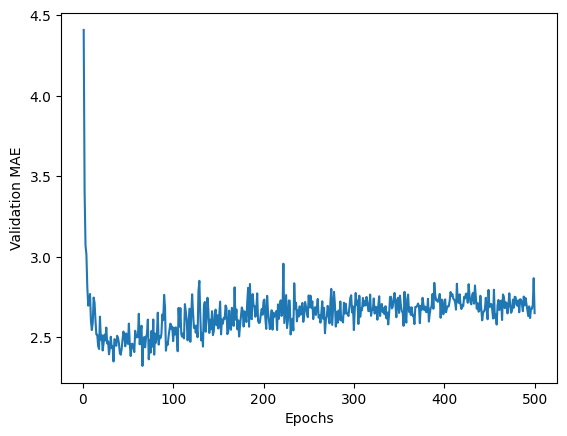

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance.
Let’s do the followin:
* Omit the first 10 data points, which are on a different scale than the rest of the curve.
* Replace each point with an exponential moving average of the previous points, 
to obtain a smooth curveg

In [16]:
def smooth_curve(points, factor=0.9): # points: a list or array of data points that you want to smooth
    # factor: smoothing factor to the previous smoothed value
    smoothed_points = [] # initialization
    for point in points: # iterates over each point in the points list.
        if smoothed_points: # checks whether smoothed_points already contains any values.
            # if it does
            previous = smoothed_points[-1] # retrieves the last smoothed value
            smoothed_points.append(previous * factor + point * (1 - factor)) # 90% weight to the previous value
        else: # If not (i.e., the list is empty), it simply appends the first point.
            smoothed_points.append(point)
    return smoothed_points

In [17]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

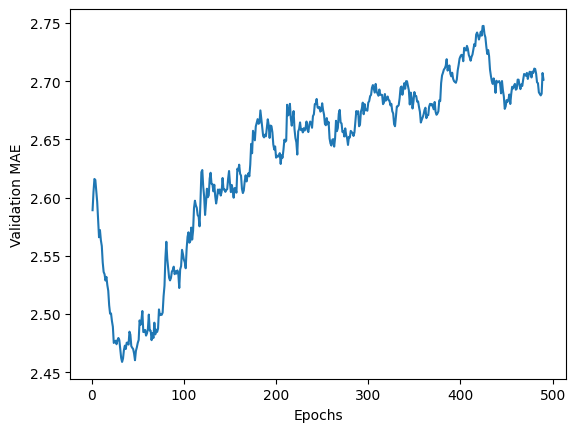

In [18]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after around 80 epochs. Past that point, you start overfitting.

In [20]:
# Training the final model
model = build_model()

model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

4/4 [==============================] - 0s 1ms/step - loss: 18.9643 - mean_absolute_error: 2.7436
2.743603229522705


You’re still off by about $2,736.

### 4.4.2 Adding weight regularizaiton

To demonstrate how to add regularization to a Feedforward Neural Network (FNN) using a real dataset, let's use the Diabetes dataset from `sklearn.datasets` to demonstrate how to apply Elastic Net regularization to a Feedforward Neural Network (FNN).

In [21]:
from sklearn.datasets import load_diabetes

# Load the diabetes dataset
data = load_diabetes()

print(data.keys()) # to inspect the Bunch object data using keys()

X = data.data
y = data.target

print(X.shape)
print(y.shape)

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])
(442, 10)
(442,)


In [22]:
# Split into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # random_state can be considered as random seed

In [23]:
# Normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We'll apply Elastic Net regularization using the `l1_l2` regularizer, which allows us to combine L1 and L2 penalties.

    * L1 (Lasso) regularization encourages sparsity (many weights become zero)
    * L2 (Ridge) regularization reduces the magnitude of all weights.

In [26]:
from tensorflow.keras.regularizers import l1_l2

def build_model_with_elastic_net():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],),
                     kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),  # Elastic Net regularization
        layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        layers.Dense(1, activation='linear')  # Output layer for regression (predicting a continuous target)
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',  # Regression loss
                  metrics=['mean_absolute_error'])
    return model

# Build the model
model = build_model_with_elastic_net()

* The values 0.001 for both L1 and L2 regularization are small, indicating a mild regularization effect. These values are often used as starting points when experimenting with regularization because:

    * They provide a balance between model complexity and regularization.
      
    * They allow the model to train without being too constrained (over-regularized) but still prevent overfitting by penalizing large weights and unnecessary complexity.

      
* These values (0.001) are chosen as a default or starting point. In practice, you may want to experiment with different regularization strengths (e.g., 0.01, 0.1, etc.) to find the best values for your dataset. A larger value would apply a stronger regularization effect, potentially improving performance for models prone to overfitting.

In [27]:
# Train the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2, 
                    verbose=2)

Epoch 1/50
9/9 - 0s - loss: 31452.1484 - mean_absolute_error: 158.4657 - val_loss: 22331.9336 - val_mean_absolute_error: 133.5701 - 357ms/epoch - 40ms/step
Epoch 2/50
9/9 - 0s - loss: 31208.4355 - mean_absolute_error: 157.7449 - val_loss: 22134.1406 - val_mean_absolute_error: 132.8710 - 21ms/epoch - 2ms/step
Epoch 3/50
9/9 - 0s - loss: 30910.8438 - mean_absolute_error: 156.8791 - val_loss: 21888.6621 - val_mean_absolute_error: 132.0085 - 21ms/epoch - 2ms/step
Epoch 4/50
9/9 - 0s - loss: 30542.1875 - mean_absolute_error: 155.7690 - val_loss: 21560.8652 - val_mean_absolute_error: 130.8608 - 21ms/epoch - 2ms/step
Epoch 5/50
9/9 - 0s - loss: 30007.7793 - mean_absolute_error: 154.2456 - val_loss: 21128.7949 - val_mean_absolute_error: 129.3467 - 21ms/epoch - 2ms/step
Epoch 6/50
9/9 - 0s - loss: 29302.7383 - mean_absolute_error: 152.1813 - val_loss: 20548.7793 - val_mean_absolute_error: 127.3151 - 21ms/epoch - 2ms/step
Epoch 7/50
9/9 - 0s - loss: 28348.6250 - mean_absolute_error: 149.3979 - v

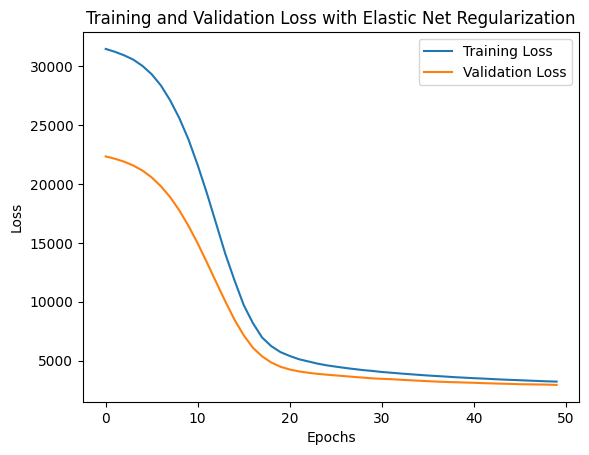

In [28]:
# Visualize Training and Validation Loss
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss with Elastic Net Regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Evaluate the Model on Test Data
test_loss, test_mae = model.evaluate(X_test, y_test)
print('Test Mean Absolute Error:', test_mae)

3/3 [==============================] - 0s 1ms/step - loss: 3346.8701 - mean_absolute_error: 45.8669
Test Mean Absolute Error: 45.86689758300781


In [30]:
# refit using epochs =30
model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=32, 
                    validation_split=0.2, 
                    verbose=2)

Epoch 1/30
9/9 - 0s - loss: 3197.9338 - mean_absolute_error: 44.7109 - val_loss: 2931.1602 - val_mean_absolute_error: 41.2276 - 36ms/epoch - 4ms/step
Epoch 2/30
9/9 - 0s - loss: 3175.1189 - mean_absolute_error: 44.5534 - val_loss: 2921.4922 - val_mean_absolute_error: 41.2911 - 19ms/epoch - 2ms/step
Epoch 3/30
9/9 - 0s - loss: 3147.1582 - mean_absolute_error: 44.3831 - val_loss: 2909.0637 - val_mean_absolute_error: 41.2515 - 19ms/epoch - 2ms/step
Epoch 4/30
9/9 - 0s - loss: 3126.1167 - mean_absolute_error: 44.2484 - val_loss: 2898.3066 - val_mean_absolute_error: 41.1626 - 19ms/epoch - 2ms/step
Epoch 5/30
9/9 - 0s - loss: 3103.6838 - mean_absolute_error: 44.1332 - val_loss: 2891.1382 - val_mean_absolute_error: 41.1578 - 18ms/epoch - 2ms/step
Epoch 6/30
9/9 - 0s - loss: 3082.4890 - mean_absolute_error: 43.9842 - val_loss: 2887.0781 - val_mean_absolute_error: 41.1780 - 19ms/epoch - 2ms/step
Epoch 7/30
9/9 - 0s - loss: 3063.0112 - mean_absolute_error: 43.8605 - val_loss: 2880.5869 - val_mea

In [31]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print('Test Mean Absolute Error:', test_mae)

3/3 [==============================] - 0s 1ms/step - loss: 3010.4519 - mean_absolute_error: 43.7259
Test Mean Absolute Error: 43.72587585449219


### 4.4.3 Adding dropout

* Dropout is one of the most effective and most commonly used regularization techniques for neural networks.

* Dropout, applied to a layer, consists of randomly dropping out 
(setting to zero) a number of output features of the layer during training.
* The dropout rate is the fraction 
of the features that are zeroed out; it’s usually set between 0.2 and 0.5
* At test time, no units are dropped out; instead, the layer’s output values are scaled down by a factor 
equal to the dropout rt..


In [32]:
# Load the Iris dataset
from sklearn.datasets import load_iris

data = load_iris()
X = data.data  # Features
y = data.target  # Target (class labels)

print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [33]:
# One-hot encode the target
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False) # initializes a OneHotEncoder object from the sklearn.preprocessing module.
y = encoder.fit_transform(y.reshape(-1, 1)) 
# This reshapes the target array y from a 1D array into a 2D column vector because OneHotEncoder expects a 2D input. 
# The -1 means that the number of rows will be inferred based on the data length.


In [34]:
print(y.shape) # 3 categories

(150, 3)


* OneHotEncoder: This is a class used to convert categorical labels (in this case, class labels) into a format that can be fed into machine learning models. Specifically, it transforms a single categorical label into a binary vector (one-hot encoded format) where each class is represented by a vector with one 1 and the rest 0.

* Dense Array Output (sparse_output=False):
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]

In [35]:
# Split into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
# Standardize the data (important for neural networks)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
# Build a Neural Network with Dropout and Elastic Net Regularization
def build_classification_model_with_regularization():
    model = keras.Sequential([
        # First hidden layer with Elastic Net (L1 + L2) and ReLU activation
        layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],),
                     kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        # Add Dropout layer with 20% dropout rate
        layers.Dropout(0.3),
        
        # Second hidden layer with Elastic Net (L1 + L2) and ReLU activation
        layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        # Add another Dropout layer with 30% dropout rate
        layers.Dropout(0.3),
        
        # Output layer for classification (Softmax activation for multi-class classification)
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
                  metrics=['accuracy'])
    return model

# Build the model
model = build_classification_model_with_regularization()

In [131]:
# Train the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=16, 
                    validation_split=0.2, 
                    verbose=2)

Epoch 1/50
6/6 - 0s - loss: 1.6424 - accuracy: 0.4583 - val_loss: 1.5363 - val_accuracy: 0.6667 - 376ms/epoch - 63ms/step
Epoch 2/50
6/6 - 0s - loss: 1.5161 - accuracy: 0.6250 - val_loss: 1.4385 - val_accuracy: 0.8750 - 18ms/epoch - 3ms/step
Epoch 3/50
6/6 - 0s - loss: 1.4524 - accuracy: 0.7083 - val_loss: 1.3446 - val_accuracy: 0.9583 - 18ms/epoch - 3ms/step
Epoch 4/50
6/6 - 0s - loss: 1.3588 - accuracy: 0.7708 - val_loss: 1.2568 - val_accuracy: 0.9167 - 19ms/epoch - 3ms/step
Epoch 5/50
6/6 - 0s - loss: 1.2875 - accuracy: 0.7604 - val_loss: 1.1783 - val_accuracy: 0.8750 - 18ms/epoch - 3ms/step
Epoch 6/50
6/6 - 0s - loss: 1.2051 - accuracy: 0.7396 - val_loss: 1.1085 - val_accuracy: 0.8750 - 17ms/epoch - 3ms/step
Epoch 7/50
6/6 - 0s - loss: 1.1413 - accuracy: 0.7708 - val_loss: 1.0427 - val_accuracy: 0.8750 - 19ms/epoch - 3ms/step
Epoch 8/50
6/6 - 0s - loss: 1.0446 - accuracy: 0.7812 - val_loss: 0.9871 - val_accuracy: 0.8750 - 18ms/epoch - 3ms/step
Epoch 9/50
6/6 - 0s - loss: 1.0158 - a

In [39]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

1/1 [==============================] - 0s 11ms/step - loss: 1.6719 - accuracy: 0.3000
Test Accuracy: 0.30000001192092896


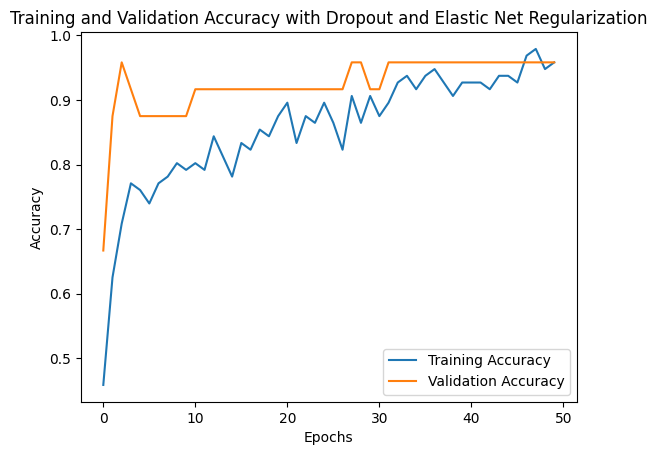

In [133]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy with Dropout and Elastic Net Regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=16, 
                    validation_split=0.2, 
                    verbose=2)

Epoch 1/20
6/6 - 0s - loss: 1.6586 - accuracy: 0.3750 - val_loss: 1.5756 - val_accuracy: 0.5417 - 300ms/epoch - 50ms/step
Epoch 2/20
6/6 - 0s - loss: 1.5299 - accuracy: 0.5625 - val_loss: 1.4730 - val_accuracy: 0.7500 - 18ms/epoch - 3ms/step
Epoch 3/20
6/6 - 0s - loss: 1.4253 - accuracy: 0.7604 - val_loss: 1.3818 - val_accuracy: 0.8333 - 17ms/epoch - 3ms/step
Epoch 4/20
6/6 - 0s - loss: 1.3725 - accuracy: 0.7083 - val_loss: 1.2987 - val_accuracy: 0.8750 - 17ms/epoch - 3ms/step
Epoch 5/20
6/6 - 0s - loss: 1.2491 - accuracy: 0.7604 - val_loss: 1.2216 - val_accuracy: 0.8333 - 17ms/epoch - 3ms/step
Epoch 6/20
6/6 - 0s - loss: 1.1887 - accuracy: 0.7708 - val_loss: 1.1558 - val_accuracy: 0.8333 - 18ms/epoch - 3ms/step
Epoch 7/20
6/6 - 0s - loss: 1.0952 - accuracy: 0.8229 - val_loss: 1.0949 - val_accuracy: 0.8333 - 17ms/epoch - 3ms/step
Epoch 8/20
6/6 - 0s - loss: 1.0521 - accuracy: 0.7812 - val_loss: 1.0408 - val_accuracy: 0.8333 - 18ms/epoch - 3ms/step
Epoch 9/20
6/6 - 0s - loss: 0.9991 - a

In [41]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

1/1 [==============================] - 0s 11ms/step - loss: 0.6464 - accuracy: 0.9667
Test Accuracy: 0.9666666388511658


# FNN for Survival Analysis

* For a survival analysis problem, a Feedforward Neural Network (FNN) can be adapted using methods such as DeepSurv or by incorporating survival-specific loss functions like the Cox Proportional Hazards loss.

* We will use the Cox Proportional Hazards loss in a neural network framework for survival prediction.

* We'll train the model to predict the hazard function for each individual based on their features.

In [153]:
pip install lifelines tensorflow pandas scikit-learn

  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
Note: you may need to restart the kernel to use updated packages.


* In this example, we used the WHAS500 dataset from the sksurv library, which contains heart failure survival data.
* The WHAS500 dataset, short for the Western Collaborative Group Study Heart Attack Study 500, is a dataset that contains information about 500 patients who were admitted to a hospital for a heart attack, with a focus on predicting survival time and analyzing factors related to cardiovascular health.

* We built a Feedforward Neural Network for survival analysis, using Cox Proportional Hazards loss and evaluated the model using the concordance index.

* The model was trained and evaluated using a custom survival loss function that accounts for censored data.

In [42]:
from sksurv.datasets import load_whas500
import pandas as pd

# Load the WHAS500 dataset
data_x, data_y = load_whas500()

print(data.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [44]:
# Convert to DataFrame for easier manipulation
df_x = pd.DataFrame(data_x)
df_y = pd.DataFrame(data_y)

df_x.head()

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
0,1,83.0,0,25.54051,0,1,78.0,0,89.0,5.0,1,0,0,152.0
1,0,49.0,0,24.02398,0,1,60.0,0,84.0,5.0,0,1,0,120.0
2,0,70.0,0,22.14290,0,0,88.0,1,83.0,5.0,0,1,0,147.0
3,0,70.0,0,26.63187,1,1,76.0,0,65.0,10.0,0,1,0,123.0
4,0,70.0,0,24.41255,0,1,85.0,0,63.0,6.0,0,1,0,135.0


In [45]:
df_y.head()
print(df_y.columns)

## lenfol: Survival time (length of follow-up)
## fstat: Censoring status (1 = event occurred, 0 = censored)

Index(['fstat', 'lenfol'], dtype='object')


In [46]:
# Combine time and event indicator with features
df_y['time'] = df_y['lenfol']
df_y['event'] = df_y['fstat']
df_y = df_y[['time', 'event']]

print(df_x.head())
print(df_y.head())

  afb   age av3       bmi chf cvd  diasbp gender    hr   los miord mitype sho  \
0   1  83.0   0  25.54051   0   1    78.0      0  89.0   5.0     1      0   0   
1   0  49.0   0  24.02398   0   1    60.0      0  84.0   5.0     0      1   0   
2   0  70.0   0  22.14290   0   0    88.0      1  83.0   5.0     0      1   0   
3   0  70.0   0  26.63187   1   1    76.0      0  65.0  10.0     0      1   0   
4   0  70.0   0  24.41255   0   1    85.0      0  63.0   6.0     0      1   0   

   sysbp  
0  152.0  
1  120.0  
2  147.0  
3  123.0  
4  135.0  
     time  event
0  2178.0  False
1  2172.0  False
2  2190.0  False
3   297.0   True
4  2131.0  False


In [47]:
# Preprocess the Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [163]:
# define a simple FNN model for survival analysis using Cox Proportional Hazards loss.
import tensorflow as tf
from tensorflow.keras import layers, models

# Custom Cox Proportional Hazards loss function
# The goal is to calculate the negative partial log-likelihood of the Cox PH model,
def cox_ph_loss(y_true, y_pred):
    time = y_true[:, 0]  # The survival time of the event or censoring
    event = y_true[:, 1]  # Event indicator of whether the event occurred (1) or was censored (0)
    # y_pred: This contains the predicted risk scores for each individual. 
    # These scores represent the model's estimate of the hazard ratio (the higher the score, the higher the estimated risk of the event occurring).

    # Sort the patients by increasing survival time
    order = tf.argsort(time) # gives the indices that would sort the time tensor in ascending order.
    time = tf.gather(time, order) 
    event = tf.gather(event, order)
    y_pred = tf.gather(y_pred, order)
    # reorders the time, event, and y_pred tensors according to the sorted order.
    
    # Calculate the risk score and cumulative risk
    risk = tf.math.exp(y_pred) # risk score
    cum_risk = tf.math.cumsum(risk[::-1])[::-1]  
    # Calculate the cumulative risk in reverse order (over all individuals who have survived up until a certain point in time.)
    log_likelihood = tf.reduce_sum(event * (y_pred - tf.math.log(cum_risk + 1e-9)))

    return -log_likelihood # minimizing negative log-likelihood (same as maximizing log-likelihood)


Example: 

* 
Imagine we have three individuals with risk scores of 2, 3, and 4, and their survival times are 10, 1 and 14 days, respectively:
  - At time 10 (when the first event happens), the sum of all risk scores for individuals who are still at risk (those who have not yet experienced the event) is 2+3+4=9.

  - A    At time 12, only two individuals (the ones with risk scores of 3 and 4) are still at risk, so the cumulative sum of their risk scores is 3

  - 
    At time 14, only the last individual (with a risk score of 4) is still at risk, so the cumulative sum is 4.

In [165]:
# Build the Feedforward Neural Network
def build_survival_model(input_shape):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation=None)  # Output layer with no activation for risk score prediction
    ])
    model.compile(optimizer='adam', loss=cox_ph_loss)
    return model

# Define the input shape and build the model
input_shape = (X_train.shape[1],)
model = build_survival_model(input_shape)

In [167]:
# Prepare the Labels for Training
# prepare the labels by combining the survival times and event indicators into a single array that can be passed to the model
# Prepare the labels for the Cox PH loss function
y_train_prepared = np.vstack([y_train['time'].values, y_train['event'].values]).T
y_test_prepared = np.vstack([y_test['time'].values, y_test['event'].values]).T

In [168]:
## Train the neural network model
history = model.fit(X_train, y_train_prepared, epochs=50, batch_size=32, validation_split=0.2, verbose=2)


Epoch 1/50
10/10 - 0s - loss: 1117.9031 - val_loss: 959.9046 - 386ms/epoch - 39ms/step
Epoch 2/50
10/10 - 0s - loss: 1095.1929 - val_loss: 957.3768 - 20ms/epoch - 2ms/step
Epoch 3/50
10/10 - 0s - loss: 1080.2302 - val_loss: 965.0781 - 20ms/epoch - 2ms/step
Epoch 4/50
10/10 - 0s - loss: 1063.6029 - val_loss: 971.7464 - 20ms/epoch - 2ms/step
Epoch 5/50
10/10 - 0s - loss: 1055.7526 - val_loss: 978.1760 - 18ms/epoch - 2ms/step
Epoch 6/50
10/10 - 0s - loss: 1052.8336 - val_loss: 981.3504 - 19ms/epoch - 2ms/step
Epoch 7/50
10/10 - 0s - loss: 1041.9797 - val_loss: 985.8730 - 19ms/epoch - 2ms/step
Epoch 8/50
10/10 - 0s - loss: 1041.5293 - val_loss: 990.4567 - 18ms/epoch - 2ms/step
Epoch 9/50
10/10 - 0s - loss: 1035.5399 - val_loss: 996.8295 - 21ms/epoch - 2ms/step
Epoch 10/50
10/10 - 0s - loss: 1029.1992 - val_loss: 1005.1849 - 18ms/epoch - 2ms/step
Epoch 11/50
10/10 - 0s - loss: 1031.2048 - val_loss: 1005.3765 - 18ms/epoch - 2ms/step
Epoch 12/50
10/10 - 0s - loss: 1029.5530 - val_loss: 1002.3

In [170]:
# Evaluate the model using the concordance index, which measures the predictive acccuracy of survival models
from sksurv.metrics import concordance_index_censored

# Predict risk scores for the test data
risk_scores = model.predict(X_test)

# Calculate the concordance index to evaluate the model's performance
c_index = concordance_index_censored(y_test['event'], y_test['time'], -risk_scores.flatten())
print(f"Concordance Index: {c_index[0]}")


4/4 [==============================] - 0s 1000us/step
Concordance Index: 0.3505572441742654


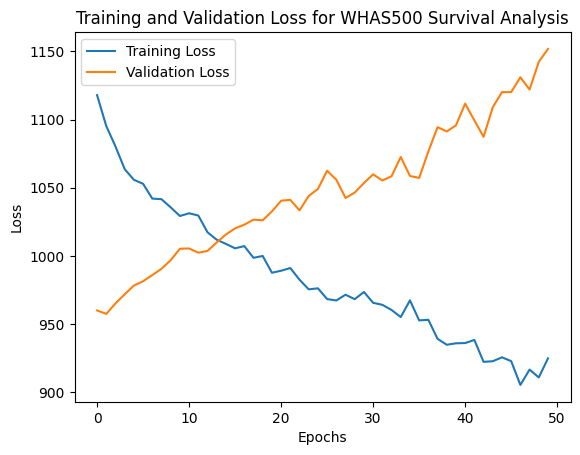

In [171]:
# visualize the training and validation loss
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for WHAS500 Survival Analysis')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [181]:
import pandas as pd
from lifelines.datasets import load_rossi

# Load the Rotterdam Tumor Recurrence dataset
data = load_rossi()

# Show the first few rows of the dataset
print(data.head())


AttributeError: module 'importlib.resources' has no attribute 'files'

# HW #7

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import load_iris
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

# Load the Iris dataset
iris = load_iris()
X = iris.data  # Features (sepal length, sepal width, petal length, petal width)
y = iris.target  # Target labels

In [2]:
# Convert the target to binary (1 for 'setosa', 0 for others)
y_binary = np.where(y == 0, 1, 0)

# Split the dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y_binary, test_size=0.2, random_state=42)


In [3]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(4,)))  # Input layer (4 features)
model.add(Dense(64, activation='relu'))  # Hidden layer 1
model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_val, y_val))

Epoch 1/50
12/12 [==============================] - 0s 9ms/step - loss: 0.5680 - accuracy: 0.6667 - val_loss: 0.4649 - val_accuracy: 0.6667
Epoch 2/50
12/12 [==============================] - 0s 2ms/step - loss: 0.4190 - accuracy: 0.7500 - val_loss: 0.3515 - val_accuracy: 0.9000
Epoch 3/50
12/12 [==============================] - 0s 2ms/step - loss: 0.3060 - accuracy: 0.9917 - val_loss: 0.2501 - val_accuracy: 1.0000
Epoch 4/50
12/12 [==============================] - 0s 2ms/step - loss: 0.2093 - accuracy: 1.0000 - val_loss: 0.1645 - val_accuracy: 1.0000
Epoch 5/50
12/12 [==============================] - 0s 2ms/step - loss: 0.1355 - accuracy: 1.0000 - val_loss: 0.1040 - val_accuracy: 1.0000
Epoch 6/50
12/12 [==============================] - 0s 2ms/step - loss: 0.0883 - accuracy: 1.0000 - val_loss: 0.0717 - val_accuracy: 1.0000
Epoch 7/50
12/12 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 1.0000
Epoch 8/50
12/12 [==

1/1 [==============================] - 0s 48ms/step - loss: 8.0264e-04 - accuracy: 1.0000
Validation Accuracy: 100.00%


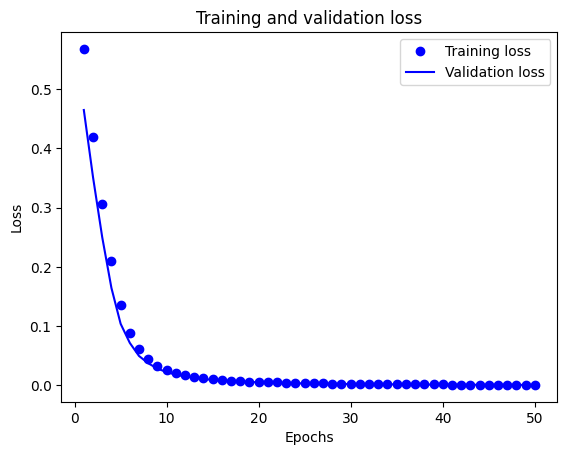

In [5]:
import matplotlib.pyplot as plt

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Plot the training and validation loss over epochs
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')  # 'bo' is for blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')  # 'b' is for solid blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [1]:
#4

import numpy as np

def relu(x):
    """ReLU activation function: returns max(0, x)"""
    return max(0, x)

def simulate_neuron(x1, x2, w1, w2, bias):
    """Simulates a single neuron with two inputs, weights, and a bias, and applies ReLU activation."""
    # Compute the linear combination of inputs and weights, plus the bias
    z = (x1 * w1) + (x2 * w2) + bias
    
    # Apply ReLU activation
    output = relu(z)
    
    return output

# Parameters
x1 = 0.5
x2 = 0.3
w1 = 0.2
w2 = 0.8
bias = -0.1

# Simulate the neuron and print the output
output = simulate_neuron(x1, x2, w1, w2, bias)
print("Neuron output:", output)


Neuron output: 0.23999999999999996


In [2]:
import numpy as np

# Activation functions
def relu(z):
    return np.maximum(0, z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Forward propagation function
def forward_propagation(x, W_1, b_1, W_2, b_2):
    # Step 1: Calculate input to the hidden layer (Z1 = W1 * x + b1)
    Z1 = np.dot(W_1, x) + b_1
    
    # Step 2: Apply ReLU activation to hidden layer (A1 = ReLU(Z1))
    A1 = relu(Z1)
    
    # Step 3: Calculate input to the output layer (Z2 = W2 * A1 + b2)
    Z2 = np.dot(W_2, A1) + b_2
    
    # Step 4: Apply sigmoid activation to output layer (A2 = Sigmoid(Z2))
    A2 = sigmoid(Z2)
    
    return A2

# Input and parameters
x = np.array([0.7, 0.5])  # Input vector
W_1 = np.array([[0.3, 0.5], [0.7, -0.1]])  # Weights between input and hidden layer
b_1 = np.array([0.2, -0.4])  # Bias for hidden layer
W_2 = np.array([0.6, -0.2])  # Weights between hidden and output layer
b_2 = 0.1  # Bias for output layer

# Perform forward propagation
output = forward_propagation(x, W_1, b_1, W_2, b_2)

print("Output of the network:", output)


Output of the network: 0.6196351704071781
